# Jane Street Market Prediction

## Libraries 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from random import sample, seed
import gc
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa

In [2]:
import janestreet
env = janestreet.make_env() # initialize the environment
iter_test = env.iter_test() # an iterator which loops over the test set

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
SEED = 666

np.random.seed(SEED)
tf.keras.backend.clear_session()
tf.random.set_seed(SEED)
seed(SEED)

## Data

In [5]:
# Load data
data = pd.read_csv('../input/jane-street-market-prediction/train.csv')
tags = pd.read_csv('../input/jane-street-market-prediction/features.csv')
tags = tags.loc[tags.feature.isin(data.columns)] # ¿?¿?¿?¿?

In [6]:
# Filter out rows where weight = 0
data = data.loc[data.weight != 0,:]
# Filter out first data
data = data.loc[data.date > 82,:]
data = data.reset_index(drop=True)
# Target variable
data['action'] = (data.resp > 0).astype(np.int8)

# resp_1 > 0 resp_2 > 0 ...
resp_cols = ['resp_1', 'resp_2', 'resp_3', 'resp', 'resp_4']
y = np.stack([(data[c] > 0).astype('int') for c in resp_cols]).T

In [7]:
# feature names
feature_names = pd.Series(data.filter(regex='feature_').columns)
feature_names_numbers = feature_names.str.slice(start=8).astype(int)

## Train/test split

In [8]:
dates = data.date.unique().tolist()
train_dates = dates[:int(round(len(dates)*0.7, 0))]
test_dates = dates[int(round(len(dates)*0.7, 0)):]

X_train = data.loc[data.date.isin(train_dates),:]
y_train = y[X_train.index,:]

X_val = data.loc[data.date.isin(test_dates),:]
y_val = y[X_val.index,:]

## NAs treatment

In [9]:
nulls = X_train.isnull().sum()
nulls_list = list(nulls[nulls >(0.1 * len(data))].index)
nulls_list

# Fill train NAs
X_train.fillna(X_train.mean(),inplace=True)

f_mean = np.mean(X_train[feature_names[1:]].values, axis=0)

# Fill val NAs
X_val.fillna(X_train.mean(), inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


## Feature names encoding

A new feature names set is defined.

New names will represent the index in the features axis of the tensor.

Features with same tags but tag4...tag0 will be in the same axis, as they are (assumed to be) the same feature measured in different timeframes.

This is assummed based on two insights:

1. it has been observed that there are many groups of features with the same tags except for tags 0...4, and there is a high correlation ~0.8 between these features.

1. Inside a group of features with different tags 0...4, the correlation between feature with tag 4 with the other features decreases as the tag value decreases (3,2,1,0).

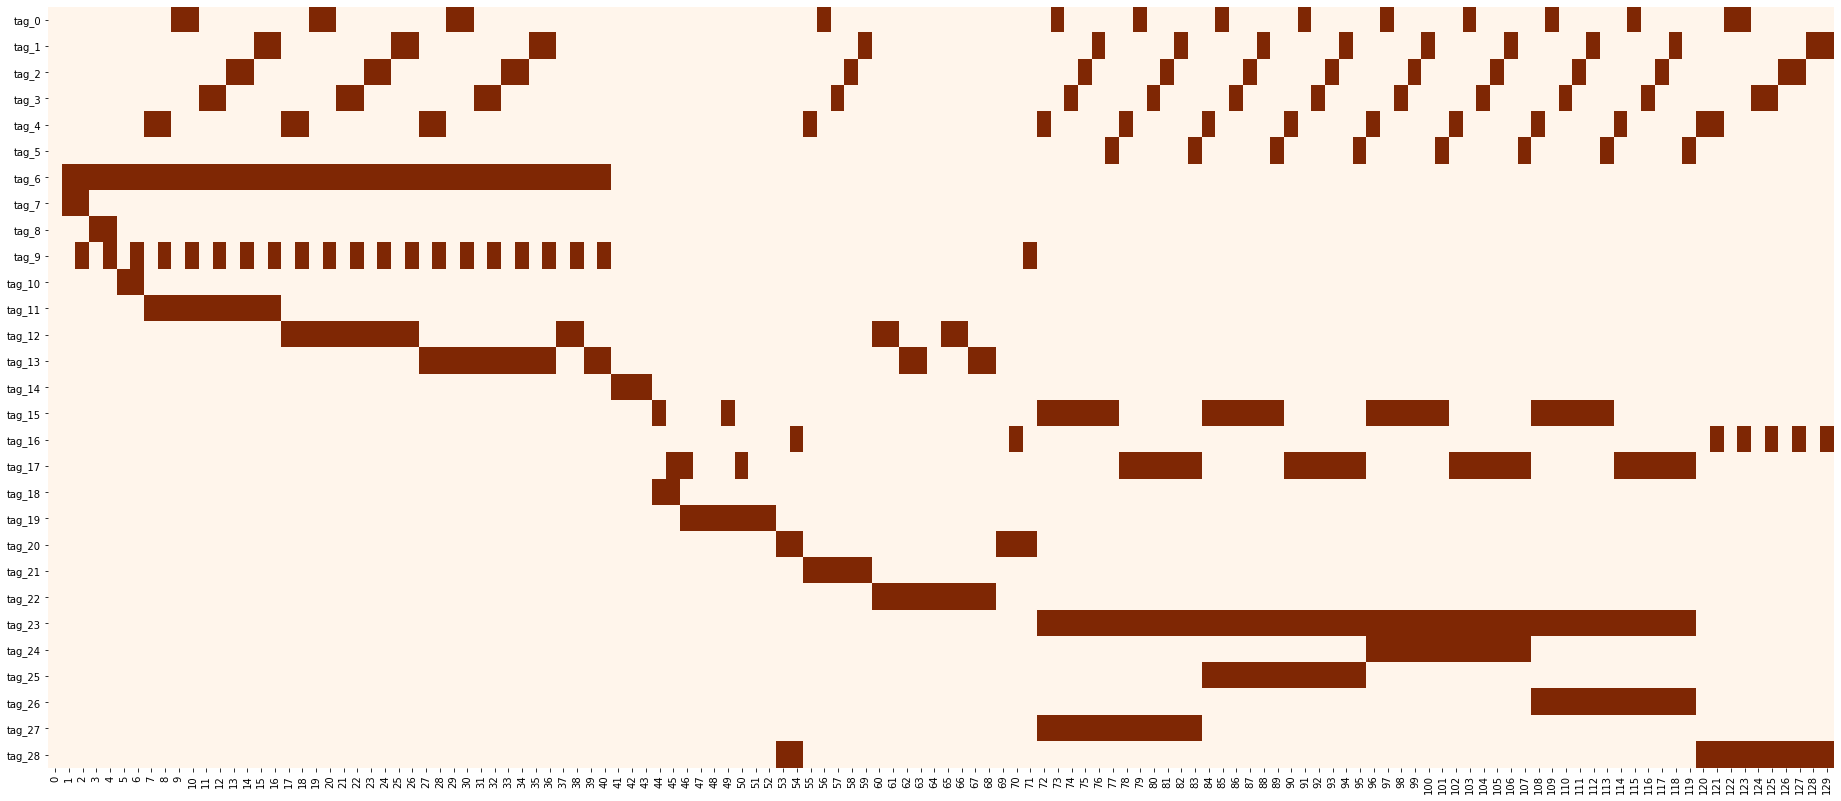

In [10]:
plt.figure(figsize=(32,14))
sns.heatmap(tags.iloc[:,1:].T,
            cbar=False,
            xticklabels=True,
            yticklabels=True,
            cmap="Oranges")
plt.show()

In [11]:
# Dict with the tags groups.
# Groups are set manually based on the observation of features with common 
# tags and the assumption that tags 0...4 represent different timeframes.
# Each group is defined by a hierarchy of levels of tags

group_tags = {
    'g0': {
        'lv0': [6],
        'lv1': [7,8,10,11,12,13],
        'lv2': [9],
        'timeframe': [4,3,2,1,0]
    },
    'g1': {
        'lv0': [14]
    },
    'g2': {
        'lv0': [18],
        'lv1': [15,17]
    },
    'g3': {
        'lv0': [19],
        'lv1': [15,17]
    },
    'g4': {
        'lv0': [21],
        'timeframe': [4,3,2,1,0]
    },
    'g5': {
        'lv0': [22],
        'lv1': [12,13]
    },
    'g6': {
        'lv0': [20],
        'lv1': [9,16]
    },
    'g7': {
        'lv0': [23],
        'lv1': [24,25,26,27],
        'lv2': [15,16,17],
        'lv3': [5],
        'timeframe': [4,3,2,1,0]
    },
    'g8': {
        'lv0': [28],
        'lv1': [20],
        'lv2': [16],
        'timeframe': [4,3,2,1,0]
    }
}

# Add 'tag_' to each tag value in the dict
group_tags_str = dict()
for group, levels in group_tags.items():
  group_tags_str[group] = {}
  for lv, lv_tags in levels.items():
    group_tags_str[group][lv] = ['tag_' + str(v) for v in lv_tags]

In [12]:
# Loop to get the new features encodings sorted by levels and sublevels
features_new_encoding = []
features_new_encoding_idx = 0
features_original = []
n_timeframes = 1 # artificial timeframes for features that don't have real timeframes

for key, value in group_tags_str.items():
  # Add combinations for lower sub level
  levels = list(value.keys())
  # If there are >=1 levels
  if len(levels) >= 1:
    for tag_lv0 in value[levels[0]]:
      # Search feature/s
      tags_set = [tag_lv0]
      features_tag = list(tags.loc[(tags.loc[:,[x not in ['feature'] + tags_set for x in list(tags.columns)]].any(axis=1) == False) & tags[tags_set].all(axis=1), 'feature'])
      # If there are features with only that tag
      if len(features_tag) > 0:
        for feature in features_tag:
            # If the feature is not in the list already
            # (Ex. feature 1 added for tag6,tag7 and then would be added for tag6,tag7,None)
            if feature not in features_original:
              # Add feature names to the old list
              features_original+=[feature] * n_timeframes
              features_new_encoding+=[features_new_encoding_idx] * n_timeframes
              features_new_encoding_idx += 1
      
      # If there are >=2 levels
      if len(levels) >= 2:
        # If the 2nd level is timeframe
        if levels[1] == 'timeframe':
          timeframe_features = []
          timeframe_features_here = False
          for tag_t in value[levels[1]]:
            # Search feature/s
            tags_set = [tag_lv0, tag_t]
            features_tag = list(tags.loc[(tags.loc[:,[x not in ['feature'] + tags_set for x in list(tags.columns)]].any(axis=1) == False) & tags[tags_set].all(axis=1), 'feature'])
            # If there is a feature with those 2 tags
            if len(features_tag) > 0:
              timeframe_features_here = True
              # Add feature names to the old list
              features_original+=features_tag
              # Add new encodings to the encoding list
              features_new_encoding+=[features_new_encoding_idx] * 1
          if timeframe_features_here:
            features_new_encoding_idx += 1
        else:
          for tag_lv1 in value[levels[1]] + [None]:
            # Create tag set for current level
            tags_set = [tag_lv0, tag_lv1]
            # Remove none
            tags_set = [x for x in tags_set if x is not None]
            # Search feature/s
            features_tag = list(tags.loc[(tags.loc[:,[x not in ['feature'] + tags_set for x in list(tags.columns)]].any(axis=1) == False) & tags[tags_set].all(axis=1), 'feature'])
            # If there are features with those 2 tags
            if len(features_tag) > 0:
              for feature in features_tag:
                # If the feature is not in the list already
                # (Ex. feature 1 added for tag6,tag7 and then would be added for tag6,tag7,None)
                if feature not in features_original:
                  # Add feature names to the old list
                  features_original+=[feature] * n_timeframes
                  features_new_encoding+=[features_new_encoding_idx] * n_timeframes
                  features_new_encoding_idx += 1
      
            # If there are >=3 levels
            if len(levels) >= 3:
              # If the 3rd level is timeframe
              if levels[2] == 'timeframe':
                timeframe_features_here = False
                for tag_t in value[levels[2]]:
                  # Create tag set for current level
                  tags_set = [tag_lv0, tag_lv1, tag_t]
                  # Remove none
                  tags_set = [x for x in tags_set if x is not None]
                  # Search feature/s
                  features_tag = list(tags.loc[(tags.loc[:,[x not in ['feature'] + tags_set for x in list(tags.columns)]].any(axis=1) == False) & tags[tags_set].all(axis=1), 'feature'])
                  # If there is a feature with those 3 tags
                  if len(features_tag) > 0:
                    timeframe_features_here = True
                    # Add feature names to the old list
                    features_original+=features_tag
                    # Add new encodings to the encoding list
                    features_new_encoding+=[features_new_encoding_idx] * 1
                if timeframe_features_here:
                  features_new_encoding_idx += 1
              else:
                for tag_lv2 in value[levels[2]] + [None]:
                  # Create tag set for current level
                  tags_set = [tag_lv0, tag_lv1, tag_lv2]
                  # Remove none
                  tags_set = [x for x in tags_set if x is not None]
                  # Search feature/s
                  features_tag = list(tags.loc[(tags.loc[:,[x not in ['feature'] + tags_set for x in list(tags.columns)]].any(axis=1) == False) & tags[tags_set].all(axis=1), 'feature'])
                  # If there are features with those 2 tags
                  if len(features_tag) > 0:
                    for feature in features_tag:
                      # If the feature is not in the list already
                      # (Ex. feature 1 added for tag6,tag7 and then would be added for tag6,tag7,None)
                      if feature not in features_original:
                        # Add feature names to the old list
                        features_original+=[feature] * n_timeframes
                        features_new_encoding+=[features_new_encoding_idx] * n_timeframes
                        features_new_encoding_idx += 1
                
                  # If there are 4 levels
                  if len(levels) >= 4:
                    # If the 4rd level is timeframe
                    if levels[3] == 'timeframe':
                      timeframe_features_here = False
                      for tag_t in value[levels[3]]:
                        # Create tag set for current level
                        tags_set = [tag_lv0, tag_lv1, tag_lv2, tag_t]
                        # Remove none
                        tags_set = [x for x in tags_set if x is not None]
                        # Search feature/s
                        features_tag = list(tags.loc[(tags.loc[:,[x not in ['feature'] + tags_set for x in list(tags.columns)]].any(axis=1) == False) & tags[tags_set].all(axis=1), 'feature'])
                        # If there is a feature with those 3 tags
                        if len(features_tag) > 0:
                          timeframe_features_here = True
                          # Add feature names to the old list
                          features_original+=features_tag
                          # Add new encodings to the encoding list
                          features_new_encoding+=[features_new_encoding_idx] * 1
                      if timeframe_features_here:
                        features_new_encoding_idx += 1
                    else:
                      for tag_lv3 in value[levels[3]] + [None]:
                        # Create tag set for current level
                        tags_set = [tag_lv0, tag_lv1, tag_lv2, tag_lv3]
                        # Remove none
                        tags_set = [x for x in tags_set if x is not None]
                        # Search feature/s
                        features_tag = list(tags.loc[(tags.loc[:,[x not in ['feature'] + tags_set for x in list(tags.columns)]].any(axis=1) == False) & tags[tags_set].all(axis=1), 'feature'])
                        # If there are features with those 2 tags
                        if len(features_tag) > 0:
                          for feature in features_tag:
                            # If the feature is not in the list already
                            # (Ex. feature 1 added for tag6,tag7 and then would be added for tag6,tag7,None)
                            if feature not in features_original:
                              # Add feature names to the old list
                              features_original+=[feature] * n_timeframes
                              features_new_encoding+=[features_new_encoding_idx] * n_timeframes
                              features_new_encoding_idx += 1

                        # If there are 5 levels (tag 5 for group 7)
                        if len(levels) == 5:
                          # If the 4rd level is timeframe
                          if levels[4] == 'timeframe':
                            timeframe_features_here = False
                            for tag_t in value[levels[4]]:
                              # Create tag set for current level
                              tags_set = [tag_lv0, tag_lv1, tag_lv2, tag_lv3, tag_t]
                              # Remove none
                              tags_set = [x for x in tags_set if x is not None]
                              # Search feature/s
                              features_tag = list(tags.loc[(tags.loc[:,[x not in ['feature'] + tags_set for x in list(tags.columns)]].any(axis=1) == False) & tags[tags_set].all(axis=1), 'feature'])
                              # If there is a feature with those 5 tags
                              if len(features_tag) > 0:
                                timeframe_features_here = True
                                # Add feature names to the old list
                                features_original+=features_tag
                                # Add new encodings to the encoding list
                                features_new_encoding+=[features_new_encoding_idx] * 1
                            if timeframe_features_here:
                              features_new_encoding_idx += 1
                          else:
                            for tag_lv4 in value[levels[4]] + [None]:
                              # Create tag set for current level
                              tags_set = [tag_lv0, tag_lv1, tag_lv2, tag_lv3, tag_lv4]
                              # Remove none
                              tags_set = [x for x in tags_set if x is not None]
                              # Search feature/s
                              features_tag = list(tags.loc[(tags.loc[:,[x not in ['feature'] + tags_set for x in list(tags.columns)]].any(axis=1) == False) & tags[tags_set].all(axis=1), 'feature'])
                              # If there are features with those 2 tags
                              if len(features_tag) > 0:
                                for feature in features_tag:
                                  # If the feature is not in the list already
                                  # (Ex. feature 1 added for tag6,tag7 and then would be added for tag6,tag7,None)
                                  if feature not in features_original:
                                    # Add feature names to the old list
                                    features_original+=[feature] * n_timeframes
                                    features_new_encoding+=[features_new_encoding_idx] * n_timeframes
                                    features_new_encoding_idx += 1
                                    

feature_names_encodings = pd.DataFrame({'feature_original': features_original, 'feature_new_encoding': features_new_encoding})
# Add feature 0, because it has no tags
feature_names_encodings = feature_names_encodings.append(pd.DataFrame({'feature_original': ['feature_0'] * n_timeframes, 'feature_new_encoding': [max(feature_names_encodings.feature_new_encoding) + 1] * n_timeframes}), ignore_index=True)


# Check that the new encoding makes sense

print('Max number original features with same new feature: ' + str(max(feature_names_encodings.groupby('feature_new_encoding')['feature_original'].nunique())))

print('Min number original features with same new feature: ' + str(min(feature_names_encodings.groupby('feature_new_encoding')['feature_original'].nunique())))

print('Are there missing features in the encoding dataframe? ', 'yes' if len(list(set(feature_names_encodings.feature_original.tolist()).symmetric_difference(feature_names))) > 0 else 'no')

# print('Nº of duplicates original features in dataframe: ' + str(sum(feature_names_encodings.feature_original.duplicated())))

Max number original features with same new feature: 5
Min number original features with same new feature: 1
Are there missing features in the encoding dataframe?  no


In [13]:
# Get features with temporal dimension
features_new_timeframe = feature_names_encodings.groupby('feature_new_encoding')['feature_original'].nunique()
features_new_timeframe = features_new_timeframe[features_new_timeframe == 5]
features_new_timeframe = features_new_timeframe.index.tolist() # Encodings of temporal features

features_timeframe = feature_names_encodings.loc[feature_names_encodings.feature_new_encoding.isin(features_new_timeframe),'feature_original'].tolist()
features_timeframe_idx = [feature_names.tolist().index(f) for f in features_timeframe] # Indexes from the subset of 'feature_X'

# Get features without temporal dimension
features_new_no_timeframe = [f for f in set(feature_names_encodings.feature_new_encoding) if f not in features_new_timeframe] # Encodings of non temporal features

features_no_timeframe = feature_names_encodings.loc[feature_names_encodings.feature_new_encoding.isin(features_new_no_timeframe),'feature_original'].tolist()
features_no_timeframe_idx = [feature_names.tolist().index(f) for f in features_no_timeframe] # Indexes from the subset of 'feature_X'

## Model

In [14]:
class ReshapeTimeframeFeatures(tf.keras.layers.Layer):
  """
  Layer aimed to reshape the input tensor to a tensor with a timeframe axis
  """
  def __init__(self, features_timeframe_idx, n_timeframes, name):
    super(ReshapeTimeframeFeatures, self).__init__()
    self.features_timeframe_idx = features_timeframe_idx
    self.n_timeframes = n_timeframes

  def build(self, input_shape):
    self.new_shape = [input_shape[0], int(len(self.features_timeframe_idx)/self.n_timeframes), self.n_timeframes]

  def call(self, input):
    # Reshape input tensor to add a timeframe dimension
    reshaped_tensor = tf.reshape(
        tensor=tf.gather(params=input, indices=self.features_timeframe_idx,axis=1),
        shape=[tf.shape(input)[0], int(len(self.features_timeframe_idx)/self.n_timeframes), self.n_timeframes]
    )
    # Transpose tensor to have the following axis order (batch, timeframe, feature)
    tensor_axis_swap = tf.transpose(reshaped_tensor, perm=[0,2,1], name=self.name)
    return tensor_axis_swap

In [15]:
batch_size = 1000
n_features_original = len(feature_names)
input_shape = (batch_size, n_features_original)
n_timeframes = 5
label_smoothing = 1e-2


inputs = tf.keras.Input(
    shape=input_shape[-1],
    dtype='float32',
    name='inputs'
)


inputs_no_timeframe = tf.gather(params=inputs, indices=features_no_timeframe_idx,axis=1, name='inputs_no_timeframe')
bn_no_timeframe = tf.keras.layers.BatchNormalization(axis=1, name='bn_no_timeframe')(inputs_no_timeframe)
dropout_inputs = tf.keras.layers.Dropout(0.1)(bn_no_timeframe)

reshape_tf = ReshapeTimeframeFeatures(features_timeframe_idx, n_timeframes, name='reshape_timeframe_feature')(inputs)
bn_timeframe = tf.keras.layers.BatchNormalization(axis=[1,2], name='bn_timeframe')(reshape_tf)
bn_timeframe = tf.transpose(bn_timeframe, [0,2,1])
bn_timeframe = tf.expand_dims(bn_timeframe, axis = 3)


lstm = tf.keras.layers.LSTM(1)

time_dist = tf.keras.layers.TimeDistributed(lstm)(bn_timeframe)
squeeze_time_dist = tf.squeeze(time_dist, axis=2)

concat_features = tf.concat(values=[dropout_inputs, squeeze_time_dist], axis=1, name='concat_features')


dense = tf.keras.layers.Dense(units=160, activation='linear', activity_regularizer=keras.regularizers.l2(1e-5))(concat_features)
bn = tf.keras.layers.BatchNormalization(axis=1)(dense)
activ = tf.keras.activations.swish(bn)


dp = tf.keras.layers.Dropout(0.1)(activ)


dense = tf.keras.layers.Dense(units=160, activation='linear', activity_regularizer=keras.regularizers.l2(1e-5))(dp)
bn = tf.keras.layers.BatchNormalization(axis=1)(dense)
activ = tf.keras.activations.swish(bn)


res_add = tf.keras.layers.add([dp, activ])

dp = tf.keras.layers.Dropout(0.1)(res_add)


dense = tf.keras.layers.Dense(units=160, activation='linear', activity_regularizer=keras.regularizers.l2(1e-5))(dp)
bn = tf.keras.layers.BatchNormalization(axis=1)(dense)
activ = tf.keras.activations.swish(bn)
dp = tf.keras.layers.Dropout(0.1)(activ)



outputs = tf.keras.layers.Dense(units=5, activation='sigmoid')(dp)


model = keras.Model(inputs=inputs, outputs=outputs, name="jane")

model.summary()

Model: "jane"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 130)]        0                                            
__________________________________________________________________________________________________
reshape_timeframe_features (Res (None, 5, 17)        0           inputs[0][0]                     
__________________________________________________________________________________________________
bn_timeframe (BatchNormalizatio (None, 5, 17)        340         reshape_timeframe_features[0][0] 
__________________________________________________________________________________________________
tf.compat.v1.transpose (TFOpLam (None, 17, 5)        0           bn_timeframe[0][0]               
_______________________________________________________________________________________________

In [16]:
MAX_EPOCHS = 200

opt = tfa.optimizers.RectifiedAdam(
    lr=1e-4
)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=label_smoothing),
    optimizer=opt,
    metrics=["AUC"]
)

callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5)

history = model.fit(
    x=X_train.loc[:, feature_names],
    y=y_train,
    batch_size=batch_size,
    epochs=MAX_EPOCHS,
    validation_data=(X_val.loc[:, feature_names], y_val),
    shuffle=True,
    callbacks=callbacks
)

Epoch 1/200
1046/1046 [==============================] - 29s 21ms/step - loss: 0.7506 - auc: 0.5040 - val_loss: 0.6959 - val_auc: 0.5268
Epoch 2/200
1046/1046 [==============================] - 19s 19ms/step - loss: 0.7076 - auc: 0.5150 - val_loss: 0.6942 - val_auc: 0.5331
Epoch 3/200
1046/1046 [==============================] - 20s 19ms/step - loss: 0.7013 - auc: 0.5210 - val_loss: 0.6935 - val_auc: 0.5365
Epoch 4/200
1046/1046 [==============================] - 20s 19ms/step - loss: 0.6984 - auc: 0.5253 - val_loss: 0.6930 - val_auc: 0.5381
Epoch 5/200
1046/1046 [==============================] - 20s 19ms/step - loss: 0.6966 - auc: 0.5283 - val_loss: 0.6925 - val_auc: 0.5391
Epoch 6/200
1046/1046 [==============================] - 20s 19ms/step - loss: 0.6953 - auc: 0.5316 - val_loss: 0.6922 - val_auc: 0.5403
Epoch 7/200
1046/1046 [==============================] - 20s 19ms/step - loss: 0.6943 - auc: 0.5343 - val_loss: 0.6920 - val_auc: 0.5402
Epoch 8/200
1046/1046 [==================

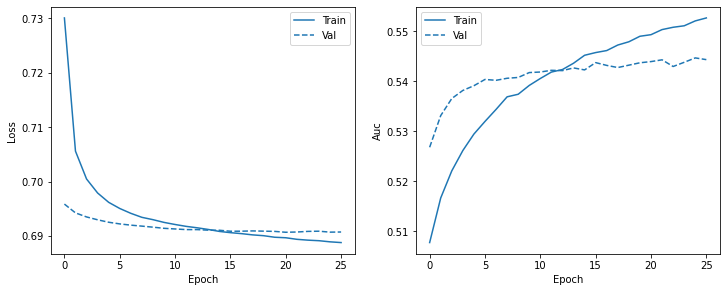

In [17]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics = ['loss', 'auc']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)

    plt.legend()
    
plot_metrics(history)

In [18]:
gc.collect()

7256

In [19]:
preds = model(X_val.loc[:, feature_names], training=False)
preds = np.median(preds, axis=1)
X_val['pred'] = preds

def utility_score(data, th):
    data['action_pred'] = (data.pred >= th).astype(int)
    data.loc[data.weight == 0, 'action_pred'] = 0
    p_values = []
    for date in data.date.unique():
        data_date = data.loc[data.date == date,:].copy()
        p_values.append(sum(data_date.weight * data_date.resp * data_date.action_pred))
    t = (sum(p_values)/np.sqrt(sum([p**2 for p in p_values])))*np.sqrt(250/len(set(data.date)))
    
    u = min(max(t,0),6)*sum(p_values)
    
    return u

best_score = 0
best_th = 0
for th in np.arange(0.45, 0.52, 0.002):
    th = np.round(th, 3)
    score = utility_score(X_val, th=th)
    if score > best_score:
        best_th = th
        best_score = score
    print(str(th) + ' - ' + str(score))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

0.45 - -0.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


0.452 - 0.4229421612906552


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


0.454 - 6.101021950983901


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


0.456 - 18.798306406195493


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


0.458 - 47.21134085512123


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


0.46 - 44.96880093334763


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


0.462 - 92.28821658245738


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


0.464 - 143.6413469922843


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


0.466 - 199.6032420316118


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


0.468 - 239.13915424719136


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


0.47 - 330.9483868832302


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


0.472 - 426.5076095531944


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


0.474 - 555.9761514141034


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


0.476 - 753.2321512871002


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


0.478 - 892.5492176059224


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


0.48 - 841.8318886383736


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


0.482 - 1056.0912415330563


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


0.484 - 1100.6606455770582


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


0.486 - 1194.6302356923768


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


0.488 - 1258.6818629090849


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


0.49 - 1371.752915364532


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


0.492 - 1450.7431329181761


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


0.494 - 1691.7697878056886


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


0.496 - 1861.281844652147


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


0.498 - 1846.8142545452615


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


0.5 - 1601.881635246862


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


0.502 - 1736.3864308536222


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


0.504 - 2020.3493162554325


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


0.506 - 2067.194155797205


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


0.508 - 2057.840180505042


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


0.51 - 1882.475017518071


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


0.512 - 1951.6634310604322


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


0.514 - 2014.3824336767843


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


0.516 - 1827.1349168346571


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


0.518 - 1874.9299282516974


## Submission

In [20]:
th = best_th

for (test_df, pred_df) in iter_test:
    if test_df['weight'].item() > 0:       
        x_tt = test_df.loc[:, feature_names].values
        if np.isnan(x_tt[:, 1:].sum()):
            x_tt[:, 1:] = np.nan_to_num(x_tt[:, 1:]) + np.isnan(x_tt[:, 1:]) * f_mean
        pred = model(x_tt, training=False)
        pred = np.median(pred)
        pred_df.action = np.where(pred >= th, 1, 0).astype(int)
    else:
        pred_df.action = 0
    
    env.predict(pred_df)